In [ ]:
import os

from dotenv import load_dotenv

load_dotenv()
import psycopg
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow

TABLE_NAME = "users_churn" # таблица с данными в postgres 

TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5001

EXPERIMENT_NAME = "churn_prediction_experiment_budikdb" # напишите название вашего эксперимента
RUN_NAME = "eda"


pd.options.display.max_columns = 100
pd.options.display.max_rows = 64


# Создаем директорию assets в папке mle-mlflow
ASSETS_DIR = "assets"
os.makedirs(ASSETS_DIR, exist_ok=True) # создает директорию, если она еще не существует

sns.set_style("white")
sns.set_theme(style="whitegrid")

connection = {
    "sslmode": "require",
    "target_session_attrs": "read-write",
    "connect_timeout": 10
}
postgres_credentials = {
    "host": os.getenv("DB_DESTINATION_HOST"),
    "port": os.getenv("DB_DESTINATION_PORT"),
    "dbname": os.getenv("DB_DESTINATION_NAME"),
    "user": os.getenv("DB_DESTINATION_USER"),
    "password": os.getenv("DB_DESTINATION_PASSWORD"),
}

connection.update(postgres_credentials)

with psycopg.connect(**connection) as conn:

    with conn.cursor() as cur:
        cur.execute(f"SELECT * FROM {TABLE_NAME}")
        data = cur.fetchall()
        columns = [col[0] for col in cur.description]

df = pd.DataFrame(data, columns=columns)

df.head(2) 

,id,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,target
0,12,7469-LKBCI,2018-10-01,NaT,Two year,No,Credit card (automatic),18.95,326.8,None,None,None,None,None,None,None,Male,0,No,No,No,0
1,13,8091-TTVAX,2015-04-01,NaT,One year,No,Credit card (automatic),100.35,5681.1,Fiber optic,No,No,Yes,No,Yes,Yes,Male,0,Yes,No,Yes,0


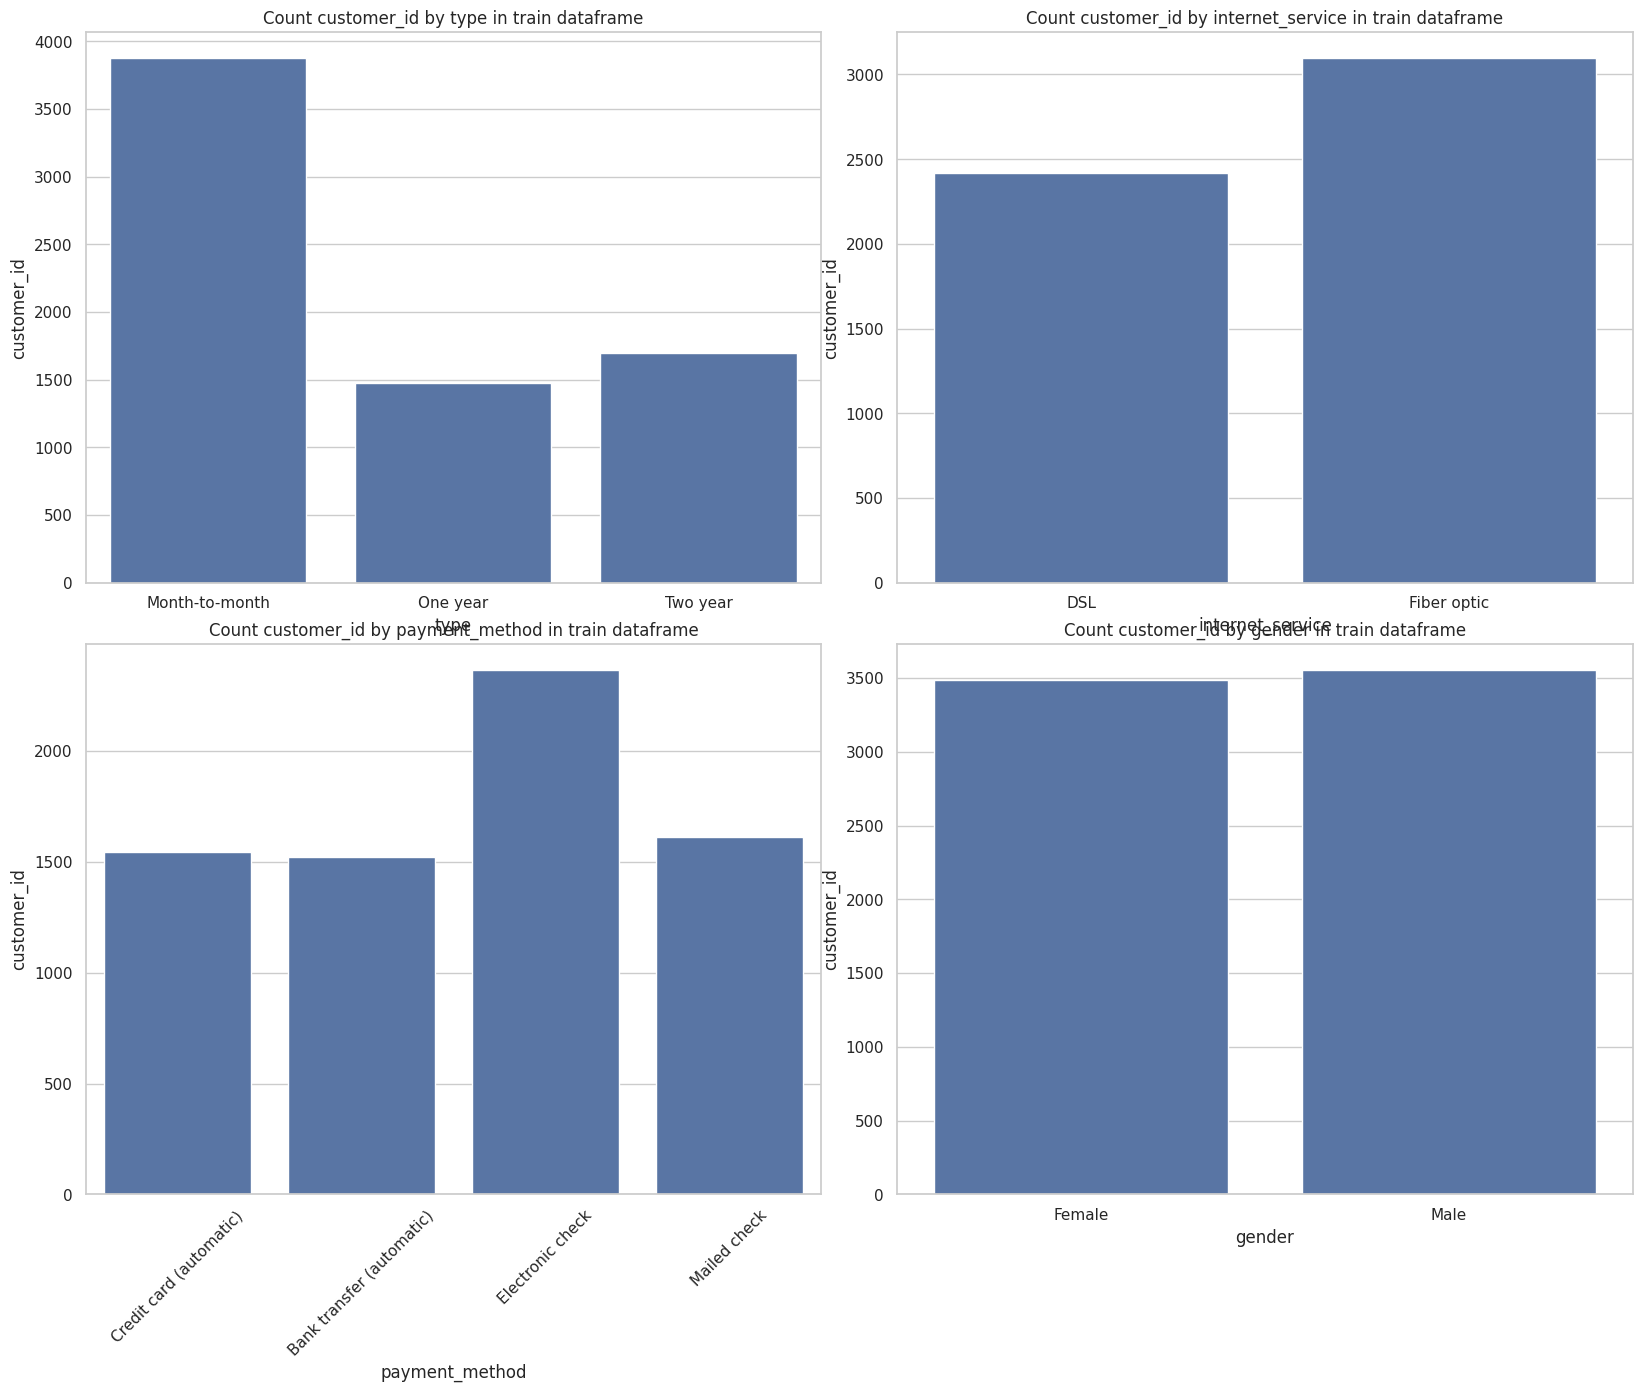

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(16.5, 12.5))
fig.set_size_inches(16.5, 12.5, forward=True)
fig.tight_layout(pad=1.6)

x = "type"
y = "customer_id"
stat = ["count"]
agg_df = df.groupby(x)[y].nunique().reset_index()
sns.barplot(data=agg_df, x=x, y=y, ax=axs[0, 0])
axs[0, 0].set_title(f'Count {y} by {x} in train dataframe')

x = "payment_method"
y = "customer_id"
stat = ["count"]
agg_df = df.groupby(x)[y].nunique().reset_index()
sns.barplot(data=agg_df, x=x, y=y, ax=axs[1, 0])
axs[1, 0].set_title(f'Count {y} by {x} in train dataframe')
axs[1, 0].set_xticks(range(len(df[x].unique())))  # Установить позиции тиков
axs[1, 0].set_xticklabels(df[x].unique(), rotation = 45)

x = "internet_service"
y = "customer_id"
stat = ["count"]
agg_df = df.groupby(x)[y].nunique().reset_index()
sns.barplot(data=agg_df, x=x, y=y, ax=axs[0, 1])
axs[0, 1].set_title(f'Count {y} by {x} in train dataframe')

x = "gender"
y = "customer_id"
stat = ["count"]
agg_df = df.groupby(x)[y].nunique().reset_index()
sns.barplot(data=agg_df, x=x, y=y, ax=axs[1, 1])
axs[1, 1].set_title(f'Count {y} by {x} in train dataframe')

plt.savefig(os.path.join(ASSETS_DIR, 'cat_features_1.png'))

In [13]:
x = "customer_id"
binary_columns = [
    "online_security", 
    "online_backup", 
    "device_protection", 
    "tech_support",
    "streaming_tv",
    "streaming_movies",
    "senior_citizen",
    "partner",
    "dependents",
]
stat = "count"
print(df.groupby(binary_columns).agg(stat)[x].reset_index().sort_values(by=x, ascending=False).head(10))

    online_security online_backup device_protection tech_support streaming_tv  \
0                No            No                No           No           No   
106              No           Yes                No           No           No   
414             Yes           Yes               Yes          Yes          Yes   
4                No            No                No           No           No   
8                No            No                No           No           No   
15               No            No                No           No          Yes   
214             Yes            No                No           No           No   
22               No            No                No           No          Yes   
413             Yes           Yes               Yes          Yes          Yes   
3                No            No                No           No           No   

    streaming_movies  senior_citizen partner dependents  customer_id  
0                 No               0 

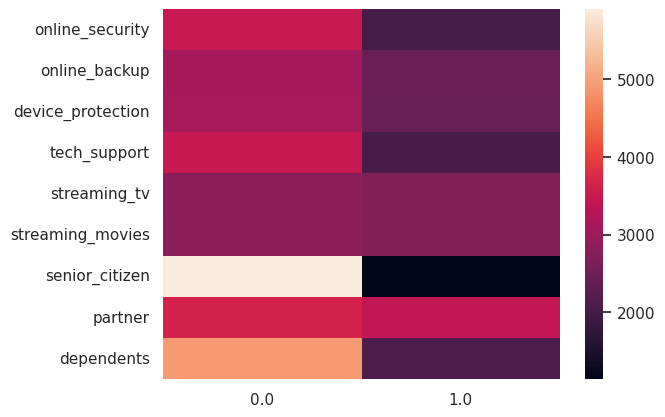

In [14]:
# Преобразуем Yes/No в 1/0 для корректного подсчета
df_binary = df[binary_columns].replace({'Yes': 1, 'No': 0})

# Теперь строим heatmap
heat_df = df_binary.apply(pd.Series.value_counts).T
sns.heatmap(heat_df)
plt.savefig(os.path.join(ASSETS_DIR, 'cat_features_2_binary_heatmap'))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


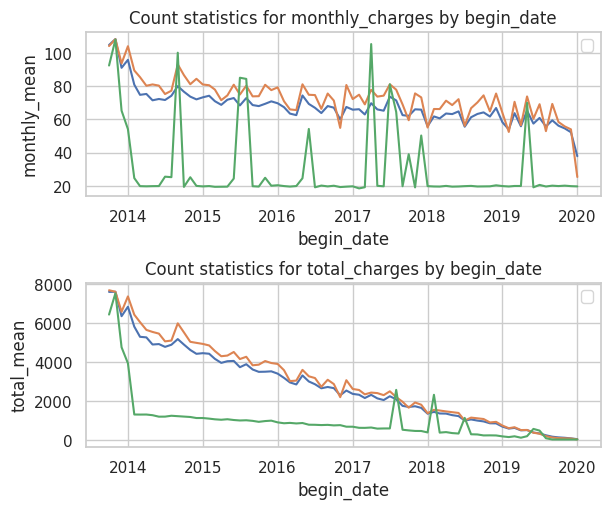

In [15]:
# инициализация переменной для названия колонки
x = "begin_date"

# список колонок, для которых будут вычисляться статистики
charges_columns = [
    "monthly_charges",
    "total_charges",
]

# удаление пустых колонок для посчёта медианного значения
df.dropna(subset=charges_columns, how='any', inplace=True)

# список статистик, которые будут вычисляться для каждой группы
stats = ["mean", "median", lambda x: x.mode().iloc[0]]  # среднее значение, медиана и мода

# группировка данных по дате начала и агрегация статистик для ежемесячных платежей (используйте reset_index для сброса индекса в таблице)
charges_monthly_agg = df[[x] + [charges_columns[0]]].groupby([x]).agg(stats).reset_index()
# удаление верхнего уровня индекса колонок (после агрегации)
charges_monthly_agg.columns = charges_monthly_agg.columns.droplevel()
# переименование колонок для удобства восприятия
charges_monthly_agg.columns = [x, "monthly_mean", "monthly_median", "monthly_mode"]

# аналогично для общих платежей
charges_total_agg = df[[x] + [charges_columns[1]]].groupby([x]).agg(stats).reset_index()
charges_total_agg.columns = charges_total_agg.columns.droplevel()
charges_total_agg.columns = [x, "total_mean", "total_median", "total_mode"]

# создание объекта для отображения графиков (2 графика вертикально)
fig, axs = plt.subplots(2, 1)
# настройка отступов между графиками
fig.tight_layout(pad=2.5)
# установка размера фигуры
fig.set_size_inches(6.5, 5.5, forward=True)

# построение линейных графиков для ежемесячных платежей
sns.lineplot(charges_monthly_agg, ax=axs[0], x=x, y='monthly_mean')
sns.lineplot(charges_monthly_agg, ax=axs[0], x=x, y='monthly_median')
sns.lineplot(charges_monthly_agg, ax=axs[0], x=x, y='monthly_mode')
axs[0].legend()
# установка заголовка для верхнего графика
axs[0].set_title(f"Count statistics for {charges_columns[0]} by {x}")

# построение линейных графиков для общих платежей
sns.lineplot(charges_total_agg, ax=axs[1], x=x, y='total_mean')
sns.lineplot(charges_total_agg, ax=axs[1], x=x, y='total_median')
sns.lineplot(charges_total_agg, ax=axs[1], x=x, y='total_mode')
axs[1].legend()

# установка заголовка для нижнего графика
axs[1].set_title(f"Count statistics for {charges_columns[1]} by {x}")

# сохранение графика в файл
plt.savefig(os.path.join(ASSETS_DIR, 'charges_by_date'))

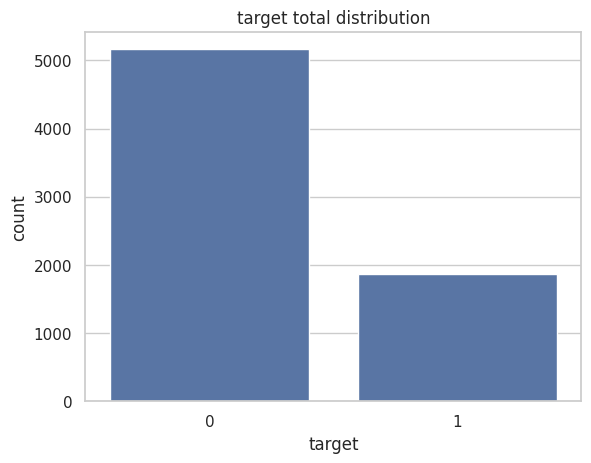

In [16]:
# директория для сохранения картинок
ASSETS_DIR = "assets"  # или укажите ваш путь к директории с артефактами

# установка названия колонки для агрегации
x = "target"

# подсчёт количества каждого уникального значения в колонке и сброс индекса для последующей визуализации
target_agg = df[x].value_counts().reset_index()
target_agg.columns = ['target', 'count']


# создание столбчатой диаграммы для визуализации распределения целевой переменной
sns.barplot(data=target_agg, x='target', y='count')

# установка заголовка графика
plt.title(f"{x} total distribution")

# сохранение графика в файл
plt.savefig(os.path.join(ASSETS_DIR, 'target_count'))

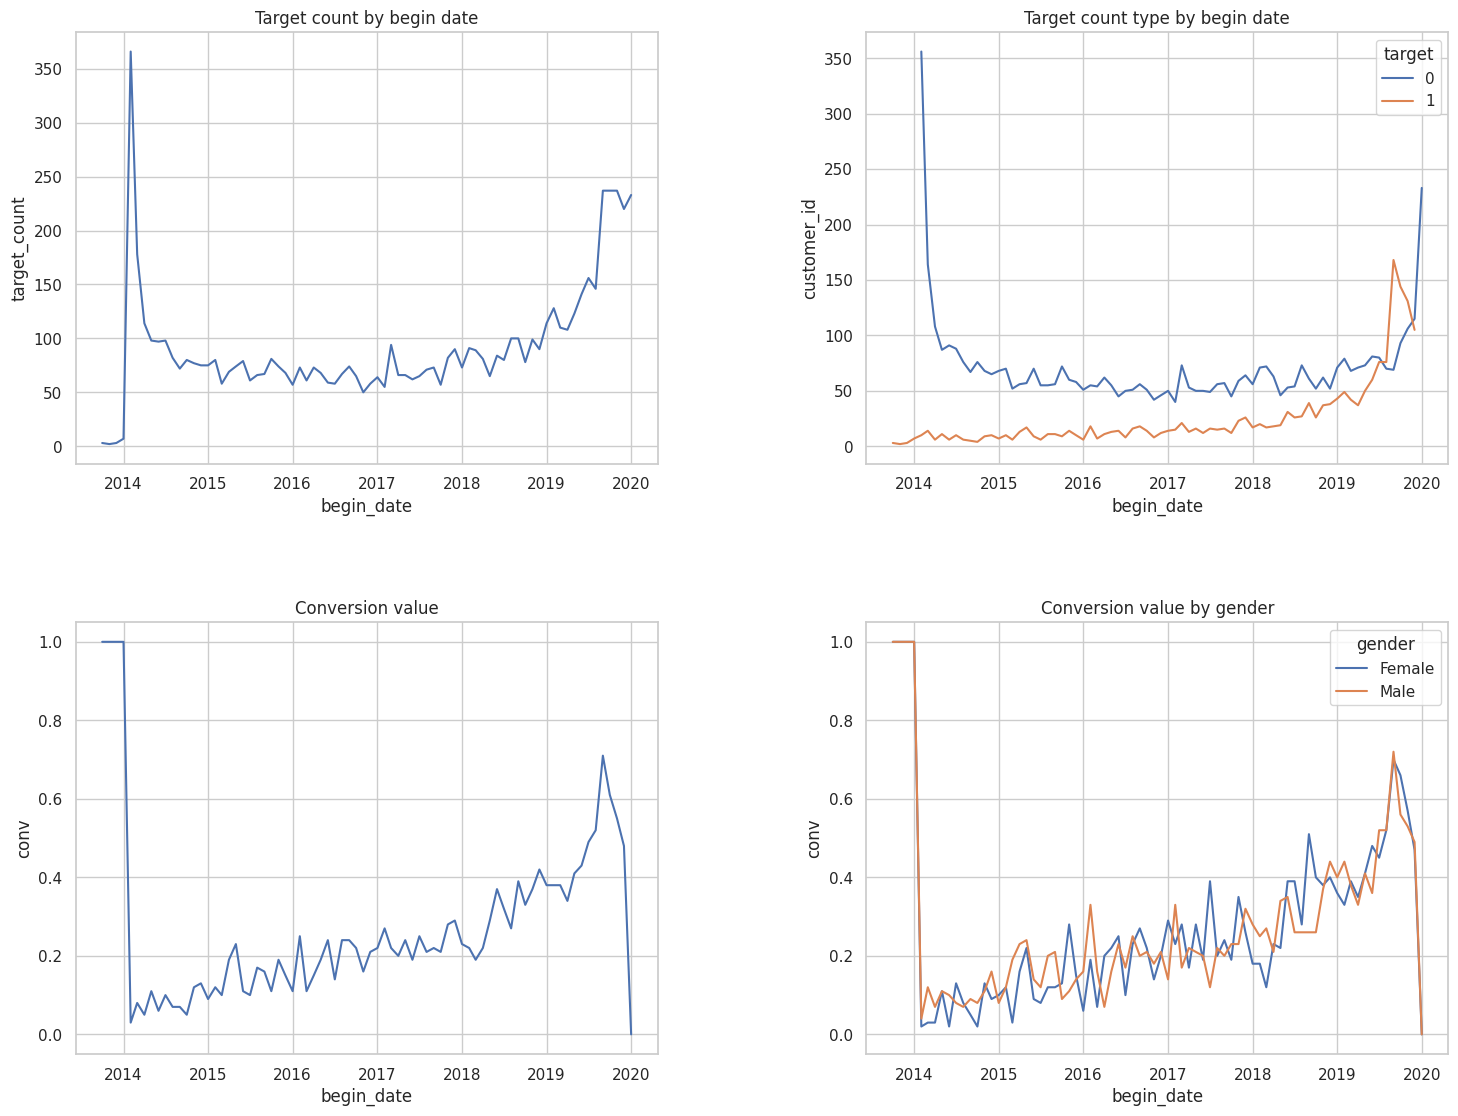

In [17]:
# установка переменных для анализа
x = "begin_date"
target = "target"

# определение статистики для агрегации
stat = "count"

# агрегация количества целей по датам начала с последующим сбросом индекса
target_agg_by_date = df[[x, target]].groupby([x]).agg(stat).reset_index()
# удаление мультиуровневости заголовков после агрегации и переименование для удобства
target_agg_by_date.columns = [x, "target_count"]

# подсчёт количества клиентов для каждого значения цели по датам
target_agg = df[[x, target, 'customer_id']].groupby([x, target]).count().reset_index()

# расчёт суммы и количества для конверсии по датам
conversion_agg = df[[x, target]].groupby([x])['target'].agg(['sum', 'count']).reset_index()
# вычисление коэффициента конверсии и округление до двух знаков
conversion_agg["conv"] = (conversion_agg["sum"] / conversion_agg["count"]).round(2)

# аналогичный расчет конверсии, но с дополнительным разделением по полу
conversion_agg_gender = df[[x, target, 'gender']].groupby([x, 'gender'])[target].agg(['sum', 'count']).reset_index()
conversion_agg_gender["conv"] = (conversion_agg_gender["sum"] / conversion_agg_gender["count"]).round(2)

# инициализация фигуры для отображения нескольких графиков
fig, axs = plt.subplots(2, 2)
fig.tight_layout(pad=1.6)  # настройка отступов между подграфиками
fig.set_size_inches(16.5, 12.5, forward=True)  # установка размера фигуры

# визуализация общего количества целей по датам начала
sns.lineplot(data=target_agg_by_date, x=x, y="target_count", ax=axs[0, 0])
axs[0, 0].set_title("Target count by begin date")

# визуализация количества клиентов для каждого типа цели по датам
sns.lineplot(data=target_agg, x=x, y="customer_id", hue=target, ax=axs[0, 1])
axs[0, 1].set_title("Target count type by begin date")

# визуализация коэффициента конверсии по датам
sns.lineplot(data=conversion_agg, x=x, y="conv", ax=axs[1, 0])
axs[1, 0].set_title("Conversion value")

# визуализация коэффициента конверсии по датам с разделением по полу
sns.lineplot(data=conversion_agg_gender, x=x, y="conv", hue="gender", ax=axs[1, 1])
axs[1, 1].set_title("Conversion value by gender")

# сохранение визуализации в файл
plt.savefig(os.path.join(ASSETS_DIR, 'target_by_date'))

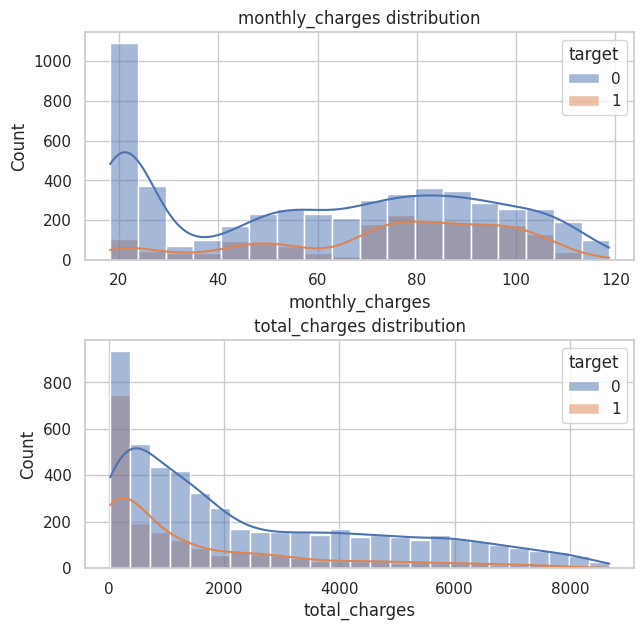

In [18]:
# определение списка столбцов с данными о платежах и целевой переменной
charges = ["monthly_charges", "total_charges"]
target = "target"

# инициализация фигуры для отображения гистограмм
fig, axs = plt.subplots(2, 1)
fig.tight_layout(pad=1.5)  # настройка отступов между подграфиками
fig.set_size_inches(6.5, 6.5, forward=True)  # установка размера фигуры

# визуализация распределения ежемесячных платежей с разделением по целевой переменной
sns.histplot(data=df, x=charges[0], hue=target, kde=True, ax=axs[0])
# датафрейм с данными
# первый вид платежей для визуализации
# разделение данных по целевой переменной
# включение оценки плотности распределения (Kernel Density Estimate)
# указание, на каком подграфике отобразить гистограмму
axs[0].set_title(f"{charges[0]} distribution")  # установка заголовка для гистограммы

# визуализация распределения общих платежей с разделением по целевой переменной
sns.histplot(data=df, x=charges[1], hue=target, kde=True, ax=axs[1])
# датафрейм с данными
# второй вид платежей для визуализации
# разделение данных по целевой переменной
# включение оценки плотности распределения
# указание, на каком подграфике отобразить вторую гистограмму
axs[1].set_title(f"{charges[1]} distribution")  # Установка заголовка для второй гистограммы

# сохранение фигуры с гистограммами в файл
plt.savefig(os.path.join(ASSETS_DIR, 'chargest_by_target_dist'))

In [1]:
import os
import dotenv

dotenv.load_dotenv()

print(os.getenv("MLFLOW_S3_ENDPOINT_URL"))

# Загружаем переменные и получаем словарь
env_vars = dotenv.dotenv_values()

print("Переменные из .env файла:")
##for key, value in env_vars.items():
##    print(f"{key} = {value}")

https://storage.yandexcloud.net
Переменные из .env файла:


In [ ]:
import os
import dotenv

dotenv.load_dotenv()

TABLE_NAME = "users_churn" # таблица с данными в postgres 

TRACKING_SERVER_HOST = "0.0.0.0"
TRACKING_SERVER_PORT = 5001

EXPERIMENT_NAME = "churn_prediction_experiment_budikdb" # напишите название вашего эксперимента
RUN_NAME = "eda"

os.environ["MLFLOW_S3_ENDPOINT_URL"] =  "***"
os.environ["AWS_ACCESS_KEY_ID"] = "***"
os.environ["AWS_SECRET_ACCESS_KEY"] = "***"

mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
ASSETS_DIR = "assets"
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id

    mlflow.log_artifacts(ASSETS_DIR)

🏃 View run eda at: http://0.0.0.0:5001/#/experiments/5/runs/56768802199c48d2a221400d39b92822
🧪 View experiment at: http://0.0.0.0:5001/#/experiments/5


S3UploadFailedError: Failed to upload /home/mle-user/mle_projects/mle-mlflow/assets/cat_features_2_binary_heatmap.png to s3-student-mle-20250130-d1608e0ec6/5/56768802199c48d2a221400d39b92822/artifacts/cat_features_2_binary_heatmap.png: An error occurred (SignatureDoesNotMatch) when calling the PutObject operation: The request signature we calculated does not match the signature you provided. Check your key and signing method.